In [81]:
import argparse
import numpy
import torch
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
from yaml import parse
import pandas as pd

In [82]:
#Using GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Train with {device}")

# Set seed
random.seed(42)
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

#Get Data Set
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)


Train with cuda


In [83]:
training_epochs = 100
batch_size = 32
learning_rate  = 0.001


In [84]:
error = torch.nn.CrossEntropyLoss().to(device)
sigmoid = torch.nn.Sigmoid().to(device)

data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)


In [85]:
class myNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = torch.nn.Linear(784, 128, bias=True).cuda()
    self.linear2 = torch.nn.Linear(128, 4, bias=True).cuda()
    self.linear3 = torch.nn.Linear(4, 10, bias = True).cuda()
    self.sigmoid = torch.nn.Sigmoid().cuda()
    torch.nn.init.xavier_uniform_(linear1.weight)
    torch.nn.init.xavier_uniform_(linear2.weight)
    torch.nn.init.xavier_uniform_(linear3.weight)
    
   
  
  def forward(self, x, flag = False):
    x = self.linear1(x)
    x = self.sigmoid(x)
    x = self.linear2(x)
    fc2out = self.sigmoid(x)
    x = self.linear3(fc2out)
    x = self.sigmoid(x)
    if flag:
        return x, fc2out
    return x

model = myNet()   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [86]:
#Train
print("Start Train Model")
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)

cost_log = []
acc_log = []

X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
Y_test = mnist_test.test_labels.to(device)

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X).cuda()
        cost = error(hypothesis, Y)
        cost.backward()
        optimizer.step()
        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

    
    
print('Learning finished')

X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
Y_test = mnist_test.test_labels.to(device)
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)
    # Test the model using test sets
    test_pred, fc2out = model(X_test, flag = True)
    test_correct = torch.argmax(test_pred, 1) == Y_test
    test_accuracy = test_correct.float().mean()


Start Train Model


/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/mglee/.conda/envs/svmglee/lib/python3.8/site-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Epoch: 0001 cost = 2.081914425
Epoch: 0002 cost = 1.855771065
Epoch: 0003 cost = 1.743567705
Epoch: 0004 cost = 1.680945277
Epoch: 0005 cost = 1.643113017
Epoch: 0006 cost = 1.619451761
Epoch: 0007 cost = 1.603300214
Epoch: 0008 cost = 1.591179490
Epoch: 0009 cost = 1.579609394
Epoch: 0010 cost = 1.569374681
Epoch: 0011 cost = 1.562458396
Epoch: 0012 cost = 1.557236314
Epoch: 0013 cost = 1.552230358
Epoch: 0014 cost = 1.545565844
Epoch: 0015 cost = 1.540485740
Epoch: 0016 cost = 1.537202477
Epoch: 0017 cost = 1.534599543
Epoch: 0018 cost = 1.532530189
Epoch: 0019 cost = 1.530853510
Epoch: 0020 cost = 1.529492021
Epoch: 0021 cost = 1.528351188
Epoch: 0022 cost = 1.527302742
Epoch: 0023 cost = 1.526428103
Epoch: 0024 cost = 1.525719166
Epoch: 0025 cost = 1.525031805
Epoch: 0026 cost = 1.524457932
Epoch: 0027 cost = 1.523858309
Epoch: 0028 cost = 1.522965670
Epoch: 0029 cost = 1.522258401
Epoch: 0030 cost = 1.517492414
Epoch: 0031 cost = 1.513893366
Epoch: 0032 cost = 1.511832833
Epoch: 0

In [87]:
df = pd.DataFrame(fc2out.cpu())
df['label'] = Y_test.cpu()
df.groupby('label').mean()

,0,1,2,3
label,,,,
0,0.040969,0.020449,0.012947,0.027212
1,0.021642,0.028103,0.566912,0.990910
2,0.723152,0.048963,0.956459,0.095277
3,0.985504,0.974477,0.243729,0.036310
4,0.986079,0.036052,0.055305,0.986734
5,0.070084,0.985120,0.023424,0.031139
6,0.035411,0.017664,0.017873,0.031753
7,0.988124,0.974391,0.976312,0.985685
8,0.059662,0.960842,0.927767,0.058226


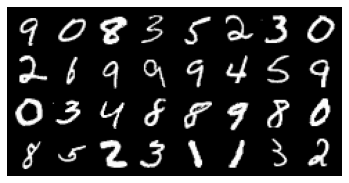

In [15]:
def imshow(img):
    # img = img / 2 + 0.5     # denormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(numpy.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(data_loader) # iterator
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))